## Misc. Utilities/setup

In [1]:
import os, time

from fastai.vision.all import *
from fastcore.all import *
from fastdownload import download_url

In [2]:
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if is_kaggle:
    data_path = Path("data")
    model_path = Path("models")
else:
    data_path = Path("../data")
    model_path = Path("../models")

data_path.mkdir(exist_ok=True, parents=True)
model_path.mkdir(exist_ok=True, parents=True)

In [3]:
def search_images(term, max_images=200):
    """
    Search duckduckgo images for the term
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(),{'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data = params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

## Figuring out search terms to scrape

In [4]:
# urls = search_images("road pothole", max_images=1)
# dest = data_path / "_pothole_example.jpg"
# download_url(urls[0], dest, show_progress=False)

# im = Image.open(dest)
# im.to_thumb(256, 256)

In [5]:
# dest = data_path / "_smooth_road_example.jpg"
# download_url(search_images("smooth road", max_images=1)[0], dest, show_progress=False)

# im = Image.open(dest)
# im.to_thumb(256, 256)

In [6]:
searches = ("pothole", "road pothole"), ("smooth", "paved road")

for o in searches:
    dest = data_path / o[0]

    # if the path already exists, assume we already fetched the images for this category
    if dest.exists():
        continue

    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{o[1]} photo", 400))
    resize_images(dest, max_size=400, dest=dest)

In [7]:
failed = verify_images(get_image_files(data_path))
failed.map(Path.unlink)
len(failed)

7

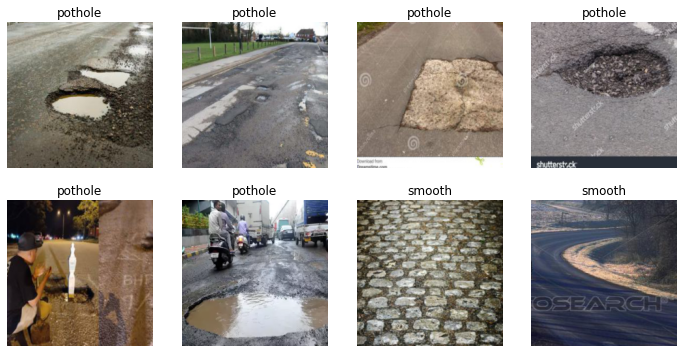

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5)
#     item_tfms=[Resize(192, method="squish")],# resize instead of RandomResizedCrop because I can't guarantee all parts of photo will feature class
)

dls = dblock.dataloaders(data_path)

dls.show_batch(max_n=8)

## Training a model to help clean data

In [9]:
learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy], y_range=(0, 1))
learn.path = model_path
learn.fine_tune(3, 1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.704748,0.567095,0.223684,0.776316,01:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.548153,0.488225,0.177632,0.822368,01:35
1,0.501202,0.445307,0.125000,0.875000,01:36
2,0.463179,0.435846,0.125000,0.875000,01:37


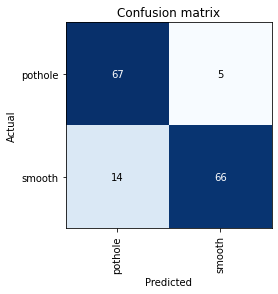

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [12]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

## Training a model post data cleanup

In [13]:
# dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
# dls = dblock.dataloaders(data_path)

# learn = vision_learner(dls, resnet18, metrics=[error_rate, accuracy], y_range=(0, 1))
# learn.path = model_path
# learn.fine_tune(5, 1e-3)

# Reference potholes
- https://www.mapillary.com/app/?lat=37.7834272&lng=-122.4090314&z=17&pKey=329277191957582&focus=photo&x=0.5071928008405571&y=0.5256868332695517&zoom=0
- https://www.mapillary.com/app/?lat=37.7838716&lng=-122.4084469&z=17&pKey=369601717767723&focus=photo&x=0.4933854378987578&y=0.5315861521217793&zoom=0
- https://www.mapillary.com/app/?lat=37.7850031&lng=-122.4071825&z=17&pKey=858857855047987&focus=photo

In [14]:
!wget https://i.imgur.com/gC2lsIx.png

--2022-06-04 18:13:12--  https://i.imgur.com/gC2lsIx.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3277298 (3.1M) [image/png]
Saving to: ‘gC2lsIx.png’

gC2lsIx.png         100%[===================>]   3.12M  5.84MB/s    in 0.5s    

2022-06-04 18:13:13 (5.84 MB/s) - ‘gC2lsIx.png’ saved [3277298/3277298]



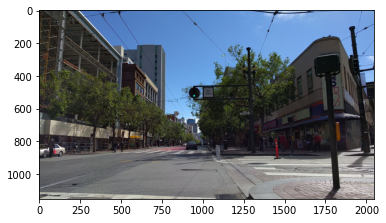

In [15]:
img = plt.imread('gC2lsIx.png')
plt.imshow(img);

In [16]:
import numpy as np

img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))


In [17]:
learn.predict(img)

('smooth', TensorBase(1), TensorBase([0.2798, 0.7202]))

--2022-06-04 18:13:15--  https://i.imgur.com/WBJt1DS.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130421 (127K) [image/png]
Saving to: ‘WBJt1DS.png’

WBJt1DS.png         100%[===================>] 127.36K   713KB/s    in 0.2s    

2022-06-04 18:13:15 (713 KB/s) - ‘WBJt1DS.png’ saved [130421/130421]



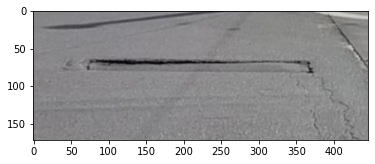

In [18]:
!wget https://i.imgur.com/WBJt1DS.png
img = plt.imread('WBJt1DS.png')
plt.imshow(img);

In [19]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('pothole', TensorBase(0), TensorBase([0.5283, 0.4717]))

--2022-06-04 18:13:17--  https://i.imgur.com/6qC1Kxz.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3757211 (3.6M) [image/png]
Saving to: ‘6qC1Kxz.png’

6qC1Kxz.png         100%[===================>]   3.58M  6.57MB/s    in 0.5s    

2022-06-04 18:13:18 (6.57 MB/s) - ‘6qC1Kxz.png’ saved [3757211/3757211]



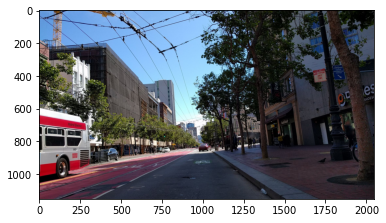

In [20]:
!wget https://i.imgur.com/6qC1Kxz.png
img = plt.imread('6qC1Kxz.png')
plt.imshow(img)

In [21]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('smooth', TensorBase(1), TensorBase([0.4342, 0.5658]))

--2022-06-04 18:13:20--  https://i.imgur.com/wkBWLdf.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91313 (89K) [image/png]
Saving to: ‘wkBWLdf.png’

wkBWLdf.png         100%[===================>]  89.17K  --.-KB/s    in 0.1s    

2022-06-04 18:13:21 (765 KB/s) - ‘wkBWLdf.png’ saved [91313/91313]



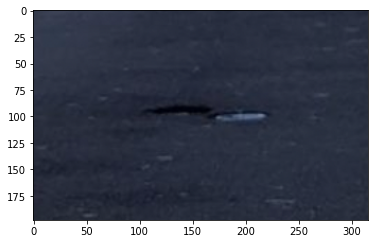

In [22]:
!wget https://i.imgur.com/wkBWLdf.png
img = plt.imread('wkBWLdf.png')
plt.imshow(img);

In [23]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('pothole', TensorBase(0), TensorBase([0.7237, 0.2763]))

--2022-06-04 18:13:22--  https://i.imgur.com/XYo6Cn1.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750163 (3.6M) [image/png]
Saving to: ‘XYo6Cn1.png’

XYo6Cn1.png         100%[===================>]   3.58M  6.58MB/s    in 0.5s    

2022-06-04 18:13:23 (6.58 MB/s) - ‘XYo6Cn1.png’ saved [3750163/3750163]



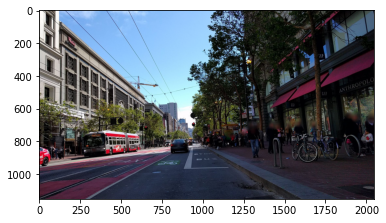

In [24]:
!wget https://i.imgur.com/XYo6Cn1.png
img = plt.imread('XYo6Cn1.png')
plt.imshow(img);

In [25]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('smooth', TensorBase(1), TensorBase([0.3249, 0.6751]))

--2022-06-04 18:13:25--  https://i.imgur.com/AD1in1n.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223728 (218K) [image/png]
Saving to: ‘AD1in1n.png’

AD1in1n.png         100%[===================>] 218.48K  1.01MB/s    in 0.2s    

2022-06-04 18:13:26 (1.01 MB/s) - ‘AD1in1n.png’ saved [223728/223728]



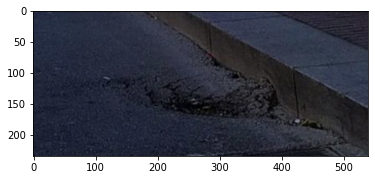

In [26]:
!wget https://i.imgur.com/AD1in1n.png
img = plt.imread('AD1in1n.png')
plt.imshow(img);

In [27]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('smooth', TensorBase(1), TensorBase([0.4921, 0.5079]))

--2022-06-04 18:13:27--  https://i.imgur.com/OFB8AZx.png
Resolving i.imgur.com (i.imgur.com)... 146.75.32.193
Connecting to i.imgur.com (i.imgur.com)|146.75.32.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146145 (143K) [image/png]
Saving to: ‘OFB8AZx.png’

OFB8AZx.png         100%[===================>] 142.72K   767KB/s    in 0.2s    

2022-06-04 18:13:28 (767 KB/s) - ‘OFB8AZx.png’ saved [146145/146145]



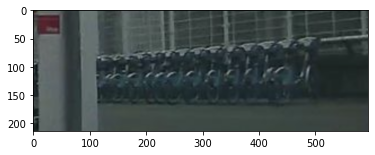

In [28]:
# Uncertainty check
!wget https://i.imgur.com/OFB8AZx.png
img = plt.imread('OFB8AZx.png')
plt.imshow(img);

In [29]:
img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize((2048, 1536)).convert('RGB'))
learn.predict(img)

('smooth', TensorBase(1), TensorBase([0.2747, 0.7253]))

In [30]:
learn.export('model.pkl')